In [1]:
#During submission internet is disabled. Hence install this package manually
!pip install -qU ../input/for-pydicom/python_gdcm-3.0.22-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl ../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl --find-links frozen_packages --no-index

In [2]:
!apt-get install -y graphviz libgraphviz-dev libcgraph6

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
libcgraph6 is already the newest version (2.42.2-6).
libcgraph6 set to manually installed.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-2 librsvg2-common libxdot4
Suggested packages:
  gvfs librsvg2-bin
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
The following packages will be upgraded:
  librsvg2-2
1 upgraded, 9 newly installed, 0 to remove and 73 not upgraded.
Need to get 5406 kB of archives.
After this operation, 7363 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu

In [3]:
!pip install git+https://github.com/danielegrattarola/spektral

  Cloning https://github.com/danielegrattarola/spektral to /tmp/pip-req-build-y4t5dzpl
  Running command git clone --filter=blob:none --quiet https://github.com/danielegrattarola/spektral /tmp/pip-req-build-y4t5dzpl
  Resolved https://github.com/danielegrattarola/spektral to commit a5fa5e38fca4eaca1e47ccfe1b00e0a61f64648b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for spektral: filename=spektral-1.3.1-py3-none-any.whl size=140164 sha256=294b85fbb3544bbd41a93114b67330bd167a5de8f60d8b697326aa7b22c7107b
  Stored in directory: /tmp/pip-ephem-wheel-cache-76gm9cej/wheels/02/e2/81/95bc0d8fb087de2ca12e892947cd5bfc3ec1046599312faf16
Successfully built spektral


In [4]:
import pandas as pd
import numpy as np
import pydicom as dicom
import glob
import nibabel as nib
import os
import re
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3, DenseNet121, InceptionResNetV2

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical, plot_model
from keras.preprocessing import image

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
pd.set_option('display.max_columns', None)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
base_dir = r'/kaggle/input/rsna-2022-cervical-spine-fracture-detection'
train_images = os.path.join(base_dir,'train_images')
test_images = os.path.join(base_dir,'test_images')
train_df = pd.read_csv(os.path.join(base_dir,'train.csv'))
segmentation_meta_data = pd.read_csv(r'/kaggle/input/rsna-cervical-fracture-segmentation-metadata/meta_segmentation.csv')

In [6]:
segmentation_meta_data.shape

(29832, 26)

In [7]:
segmentation_meta_data.columns

Index(['Rows', 'Columns', 'SOPInstanceUID', 'ContentDate', 'SliceThickness',
       'InstanceNumber', 'ImagePositionPatientX', 'ImagePositionPatientY',
       'ImagePositionPatientZ', 'PhotometricInterpretation', 'PixelSpacingX',
       'PixelSpacingY', 'WindowCenter', 'WindowWidth', 'RescaleIntercept',
       'RescaleSlope', 'StudyInstanceUID', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'Slice', 'SliceRatio'],
      dtype='object')

In [8]:
columns = ['StudyInstanceUID','SOPInstanceUID','C1','C2','C3','C4','C5','C6','C7']
seg_labels = segmentation_meta_data[columns]
seg_labels.head(2)

,StudyInstanceUID,SOPInstanceUID,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.12,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.120,0,0,0,0,1,1,0


In [9]:
#Get Slice instance number
seg_labels.loc[:,'slice'] = seg_labels['SOPInstanceUID'].apply(lambda x:x.split('.')[-1:][0])
seg_labels

/tmp/ipykernel_32/452365418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seg_labels.loc[:,'slice'] = seg_labels['SOPInstanceUID'].apply(lambda x:x.split('.')[-1:][0])


,StudyInstanceUID,SOPInstanceUID,C1,C2,C3,C4,C5,C6,C7,slice
0,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.12,0,0,0,0,0,0,0,12
1,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.120,0,0,0,0,1,1,0,120
2,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.141,0,0,0,0,0,1,1,141
3,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.18,0,0,0,0,0,0,0,18
4,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.9,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...
29827,1.2.826.0.1.3680043.26990,1.2.826.0.1.3680043.26990.1.26,0,0,0,0,0,0,0,26
29828,1.2.826.0.1.3680043.26990,1.2.826.0.1.3680043.26990.1.185,0,0,0,0,0,1,1,185
29829,1.2.826.0.1.3680043.26990,1.2.826.0.1.3680043.26990.1.221,0,0,0,0,0,0,0,221
29830,1.2.826.0.1.3680043.26990,1.2.826.0.1.3680043.26990.1.13,0,0,0,0,0,0,0,13


In [10]:
# Function to load DICOM images
def load_scan(dcm_paths):  
    patient_scan = [dicom.dcmread(paths) for paths in dcm_paths]
    return patient_scan

def get_pixels_hu(img):
    image = cv2.resize(img.pixel_array,(128, 128),interpolation = cv2.INTER_NEAREST)
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0, the intercept is usually -1024, so air is approximately 0
    image[image <= -1000] = 0
    # Convert to Hounsfield units (HU)    
    intercept = np.array(img.RescaleIntercept)
    slope = np.array(img.RescaleSlope)
    image= (slope * image.astype("float64")) + intercept
#     plt.imshow(image.astype("int16"), cmap='bone') 
    return image.astype("int16")

In [11]:
list(seg_labels['StudyInstanceUID'].unique())

['1.2.826.0.1.3680043.1363',
 '1.2.826.0.1.3680043.25704',
 '1.2.826.0.1.3680043.20647',
 '1.2.826.0.1.3680043.31077',
 '1.2.826.0.1.3680043.17960',
 '1.2.826.0.1.3680043.1573',
 '1.2.826.0.1.3680043.18935',
 '1.2.826.0.1.3680043.1868',
 '1.2.826.0.1.3680043.26442',
 '1.2.826.0.1.3680043.27752',
 '1.2.826.0.1.3680043.12281',
 '1.2.826.0.1.3680043.26068',
 '1.2.826.0.1.3680043.8024',
 '1.2.826.0.1.3680043.11827',
 '1.2.826.0.1.3680043.1542',
 '1.2.826.0.1.3680043.26740',
 '1.2.826.0.1.3680043.26898',
 '1.2.826.0.1.3680043.16092',
 '1.2.826.0.1.3680043.8744',
 '1.2.826.0.1.3680043.8884',
 '1.2.826.0.1.3680043.5002',
 '1.2.826.0.1.3680043.3992',
 '1.2.826.0.1.3680043.20120',
 '1.2.826.0.1.3680043.780',
 '1.2.826.0.1.3680043.30067',
 '1.2.826.0.1.3680043.5671',
 '1.2.826.0.1.3680043.18968',
 '1.2.826.0.1.3680043.26979',
 '1.2.826.0.1.3680043.21651',
 '1.2.826.0.1.3680043.17481',
 '1.2.826.0.1.3680043.27016',
 '1.2.826.0.1.3680043.1480',
 '1.2.826.0.1.3680043.18480',
 '1.2.826.0.1.3680043.1

In [12]:
def get_image(study_instance):
    path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images'
    # study_instances = list(seg_labels['StudyInstanceUID'].unique())
    patient_slices = []
    org_images = []
#     study_instance = '1.2.826.0.1.3680043.1868'
    # for study_instance in study_instances:
    slices = list(seg_labels[seg_labels['StudyInstanceUID']==study_instance]['slice'])
    dcm_paths = [path+'/'+study_instance+'/'+ slic + '.dcm' for slic in slices]
    image = load_scan(dcm_paths)
    org_images.append(image)
    slices_p = [dicom.read_file(dcm_path) for dcm_path in dcm_paths]
    patient_slice = [get_pixels_hu(slic) for slic in slices_p]
    patient_slices.append(patient_slice)
    
    return org_images, patient_slices, slices

In [13]:
study_instance = '1.2.826.0.1.3680043.1868'
org_images, patient_slices, slices = get_image(study_instance = study_instance)

In [14]:
dat  = seg_labels[seg_labels['StudyInstanceUID']==study_instance][['SOPInstanceUID', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']]
dat

,SOPInstanceUID,C1,C2,C3,C4,C5,C6,C7
2273,1.2.826.0.1.3680043.1868.1.377,0,0,0,0,1,1,0
2274,1.2.826.0.1.3680043.1868.1.257,0,1,1,0,0,0,0
2275,1.2.826.0.1.3680043.1868.1.240,0,1,1,0,0,0,0
2276,1.2.826.0.1.3680043.1868.1.452,0,0,0,0,0,1,1
2277,1.2.826.0.1.3680043.1868.1.553,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2921,1.2.826.0.1.3680043.1868.1.221,0,1,0,0,0,0,0
2922,1.2.826.0.1.3680043.1868.1.13,0,0,0,0,0,0,0
2923,1.2.826.0.1.3680043.1868.1.358,0,0,0,1,1,0,0
2924,1.2.826.0.1.3680043.1868.1.566,0,0,0,0,0,0,0


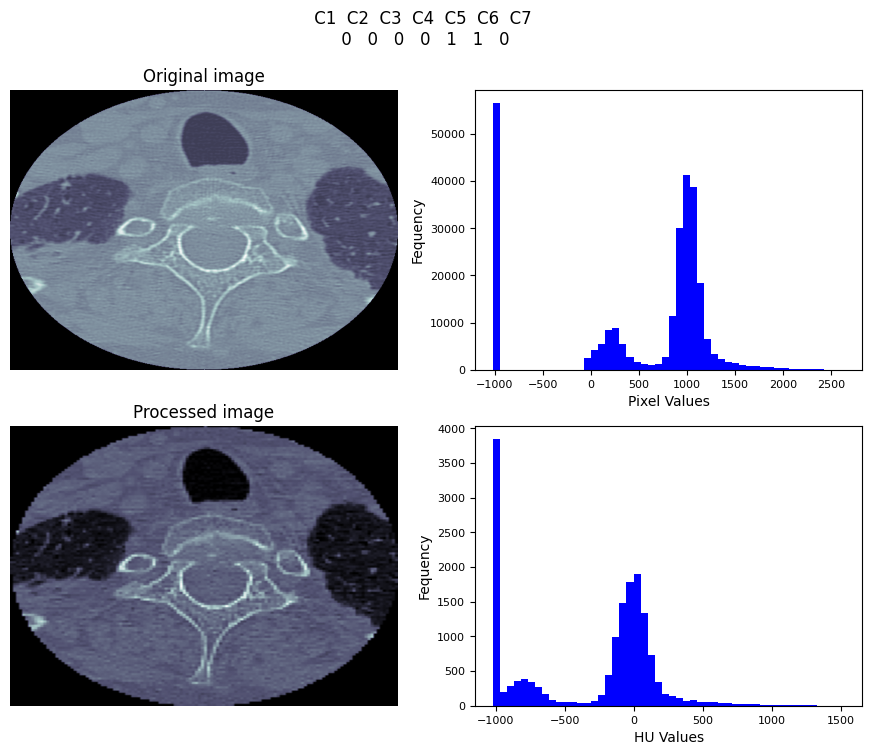

In [15]:
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)

start = 0
img = 67
label = dat[dat['SOPInstanceUID']==study_instance+'.1.'+slices[start]][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].to_string(index=False).split('\n')
plt.figure(figsize=(11, 8))
# Ploting pixel array
plt.subplot(2, 2, 1)
plt.imshow(org_images[start][img].pixel_array,cmap='bone', aspect='auto')
plt.title('Original image')
plt.axis("off")

# Ploting pixel array distribution
plt.subplot(2, 2, 2)
plt.hist(org_images[start][img].pixel_array.flatten(),color="b",bins=50)
# plt.title('Pixel array distribution')
plt.xlabel("Pixel Values")
plt.ylabel("Fequency")

#Ploting HU array
plt.subplot(2, 2, 3)
plt.imshow(get_pixels_hu(org_images[start][img]),cmap='bone', aspect='auto')
plt.title('Processed image')
plt.axis("off")

# Ploting HU distribution
plt.subplot(2, 2, 4)
plt.hist(patient_slices[start][img].flatten(),color="b",bins=50)
# plt.title('HU distribution')
plt.xlabel("HU Values")
plt.ylabel("Fequency")
plt.suptitle(f"{label[0]} \n {label[1].strip()}", y=0.98, fontsize=12)
plt.show()

In [16]:
label, label[1].split()

([' C1  C2  C3  C4  C5  C6  C7', '  0   0   0   0   1   1   0'],
 ['0', '0', '0', '0', '1', '1', '0'])

In [17]:
def load_dicom(path):
    '''
    Function to load and transform DICOM images.
    
    Parameters:
    path(string): Path to the DICOM images

    Returns:
    Transformed and resized image.
    
    '''
    img=dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
#     data=img.pixel_array
    data=get_pixels_hu(img)
    data=data-np.min(data)
    if np.max(data) != 0:
        data=data/np.max(data)
    data=(data*255).astype(np.uint8)        
    return cv2.cvtColor(data.reshape(128, 128), cv2.COLOR_GRAY2RGB)

def ImgDataGenerator(train_df,base_path):
    '''
    Function to read dicom image path and store the images as numpy arrays.

    Parameters:
    train_df: Pandas dataframe.
    base_path: Python list containing image filepaths.

    Returns:
    [Train image dataset, Train image labels]

    '''
    trainset = []
    trainlabel = []
    for i in tqdm(range(len(train_df))):
        study_id = train_df.loc[i,'StudyInstanceUID']
        slice_id = train_df.loc[i,'slice']+'.dcm'
        study_path = study_id+'/'+slice_id

        path = os.path.join(base_path, study_path)

        img = load_dicom(path)
        img = cv2.resize(img, (128 , 128))
        image = img_to_array(img)
        image = image / 255.0
        trainset += [image]
        cur_label = [train_df.loc[i,f'C{j}'] for j in range(1,8)]
        trainlabel += [cur_label]

    return np.array(trainset), np.array(trainlabel)
    
def metrics(y_test, y_pred_binary):
    '''
    Function to display accuracy, precision, recall and f1-score for the classification task.
    
    Parameters:
    y_test: True labels.
    y_pred_binary: Predicted binary labels.

    Returns:
    Pandas dataframe containing class-wise Sensitivity, Specificity, and F1-score.
    
    '''
    classes = np.array(seg_labels.columns[2:-1])
    df_res = []
    precision_per_class = precision_score(y_test, y_pred_binary, average=None)
    recall_per_class = recall_score(y_test, y_pred_binary, average=None)
    f1_per_class = f1_score(y_test, y_pred_binary, average=None)

    for i in range(len(classes)):
        df_res.append([classes[i], recall_per_class[i], precision_per_class[i], f1_per_class[i]])
    df_res = pd.DataFrame(df_res, columns = ['Class','Sensitivity','Specificity', 'F1-score'])
    return df_res

def plot_history(history):
    '''
    Function to plot the train and validation accuracy and loss.
    
    Parameters:
    history: model train history

    Returns:
    None.
    
    '''
    hist = history.history
    plt.figure(figsize=(8, 4));
    plt.suptitle(f"Performance Metrics", fontsize=12)

    # Actual and validation losses
    plt.subplot(1, 2, 1);
    plt.plot(hist['loss'], label='train')
    plt.plot(hist['val_loss'], label='validation')
    plt.title('Train and val loss curve', fontsize=8)
    plt.legend()

    # Actual and validation accuracy
    plt.subplot(1, 2, 2);
    plt.plot(hist['binary_accuracy'], label='train')
    plt.plot(hist['val_binary_accuracy'], label='validation')
    plt.title('Train and val accuracy curve', fontsize=8)
    plt.legend();
    
def callback(model_name, patience=5): 
    '''
    Function to define callback for model training.
    
    Parameters:
    model_name(string): Name for the saved model with `.h5` extension.
    patience: Patience for early stopping. Usually, the value lies between 5-11.

    Returns:
    [Early Stopping Callback, Model Checkpoint Callback]
    
    '''
    early_stopping = callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    model_checkpoint = callbacks.ModelCheckpoint(model_name, save_best_only=True)
    learning_rate_reduction = callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                                        patience=2, 
                                                        verbose=1, 
                                                        factor=0.5, 
                                                        min_lr=0.00001)
    return [early_stopping, model_checkpoint, learning_rate_reduction]


In [18]:
# Convert train images of segmented studyids to array
X_seg, y_seg = ImgDataGenerator(seg_labels,train_images)
X_seg.shape,y_seg.shape

100%|██████████| 29832/29832 [09:36<00:00, 51.77it/s]


((29832, 128, 128, 3), (29832, 7))

In [19]:
# Divide train and test data
X_train, X_test, y_train, y_test = train_test_split(X_seg, y_seg, random_state=42, test_size=0.1)
y_train, y_test = y_train.astype('float32'), y_test.astype('float32')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((26848, 128, 128, 3), (26848, 7), (2984, 128, 128, 3), (2984, 7))

In [20]:
labels = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

# **Data Augmentation** 

In [28]:
import tensorflow as tf

def augment(image, label):
    '''
    Data augmentation function using TensorFlow operations.
    '''
    # Random rotations
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Random horizontal shifts
    if tf.random.uniform(shape=[]) > 0.5:
        image = tf.image.flip_left_right(image)

    # Random vertical shifts
    if tf.random.uniform(shape=[]) > 0.5:
        image = tf.image.flip_up_down(image)

    # Random brightness adjustment
    image = tf.image.adjust_brightness(image, delta=0.1)

    # Random contrast adjustment
    image = tf.image.adjust_contrast(image, contrast_factor=0.1)

    return image, label


In [29]:

# Create TensorFlow datasets WITH AUGMENTATION
X_train_tensor = tf.data.Dataset.from_tensor_slices(X_train)
y_train_tensor = tf.data.Dataset.from_tensor_slices(y_train)

# Combine image and label tensors
train_dataset = tf.data.Dataset.zip((X_train_tensor, y_train_tensor))

# Apply augmentation
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, and prefetch
train_dataset = train_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset (no augmentation)
X_test_tensor = tf.data.Dataset.from_tensor_slices(X_test)
y_test_tensor = tf.data.Dataset.from_tensor_slices(y_test)
val_dataset = tf.data.Dataset.zip((X_test_tensor, y_test_tensor))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [21]:
# Prepare data batches for training images
X_train_tensor = tf.data.Dataset.from_tensor_slices(X_train)
y_train_tensor = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((X_train_tensor, y_train_tensor)).batch(16).prefetch(tf.data.AUTOTUNE)
# Prepare data batches for validation images
X_test_tensor = tf.data.Dataset.from_tensor_slices(X_test)
y_test_tensor = tf.data.Dataset.from_tensor_slices(y_test)
val_dataset = tf.data.Dataset.zip((X_test_tensor, y_test_tensor)).batch(16).prefetch(tf.data.AUTOTUNE)

In [30]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = []
for i in range(y_train.shape[1]):
    weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_train[:, i].astype(int)
    )
    class_weights.append(weights[1])  # Weight for positive class

class_weights = np.array(class_weights, dtype=np.float32)
print("Class weights:", class_weights)


Class weights: [3.627128  2.2451916 3.7011304 3.5664186 3.496744  3.389043  3.0329869]


In [31]:
import tensorflow.keras.backend as K
import tensorflow as tf

def weighted_binary_crossentropy(class_weights):
    class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
    def loss(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        weighted_bce = bce * class_weights_tensor
        return K.mean(weighted_bce)
    return loss


In [ ]:
def get_basic_cnn():
    
    '''Basic Convolutional Neural Network to train segmentation CT scan images'''
    
    
    inp = tfl.Input((128, 128 ,3))
    x = tfl.Conv2D(32, (3, 3), activation='relu')(inp)
    x = tfl.MaxPooling2D((2, 2))(x)
    x = tfl.Conv2D(64, (3, 3), activation='relu')(inp)
    x = tfl.MaxPooling2D((2, 2))(x)
    x = tfl.Conv2D(128, (3, 3), activation='relu')(inp)
    x = tfl.MaxPooling2D((2, 2))(x)
    x = tfl.Flatten()(x)
    x = tfl.Dense(128, 'relu')(x)
    x = tfl.Dropout(0.5)(x)
    out = tfl.Dense(7, 'sigmoid')(x)
    
    model = tf.keras.models.Model(inp, out)
    
    model.compile(loss="binary_crossentropy",
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
                  metrics=[tf.keras.metrics.BinaryAccuracy()])
    model.summary()
    
    return model

#recall, precision. Way to use softmax [1,0,0,0,1,0,0] -> [0.5,0,0,0,0.5,0,0]

219055592/219055592 [==============================] - 8s 0us/step


In [23]:
model_0 = model

In [ ]:
# Compile the model
model_0.compile(loss="binary_crossentropy",
              optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Train the model
history_model_0 = model_0.fit(train_dataset, 
                              epochs=100, 
                              validation_data=val_dataset,
                              steps_per_epoch=int(len(train_dataset)/32),
                              validation_steps=int(len(val_dataset)),
                              callbacks=[callback(patience=15, model_name="model_0_CustomCNN.h5")])

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
52/52 [==============================] - 48s 565ms/step - loss: 0.5455 - binary_accuracy: 0.7601 - val_loss: 0.5820 - val_binary_accuracy: 0.8422 - lr: 0.0100
Epoch 2/100
52/52 [==============================] - 26s 495ms/step - loss: 0.4353 - binary_accuracy: 0.8410 - val_loss: 0.5361 - val_binary_accuracy: 0.8422 - lr: 0.0100
Epoch 3/100
52/52 [==============================] - 25s 479ms/step - loss: 0.4039 - binary_accuracy: 0.8484 - val_loss: 0.4872 - val_binary_accuracy: 0.8422 - lr: 0.0100
Epoch 4/100
52/52 [==============================] - 24s 469ms/step - loss: 0.3819 - binary_accuracy: 0.8479 - val_loss: 0.4481 - val_binary_accuracy: 0.8422 - lr: 0.0100
Epoch 5/100
52/52 [==============================] - 25s 477ms/step - loss: 0.3633 - binary_accuracy: 0.8484 - val_loss: 0.4130 - val_binary_accuracy: 0.8422 - lr: 0.0100
Epoch 6/100
52/52 [==============================] - 25s 482ms/step - loss: 0.3469 - binary_accuracy: 0.8482 - val_loss: 0.3571 - val_binary_accu

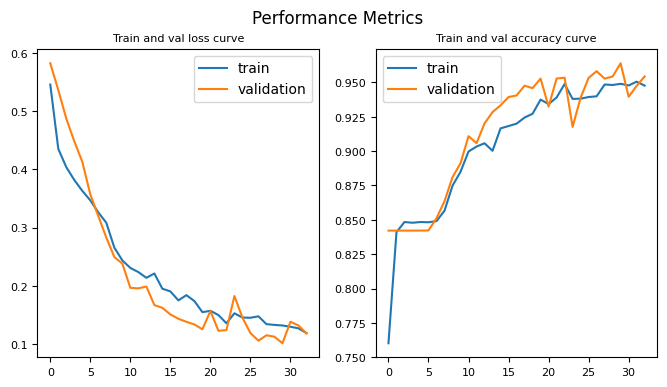

In [27]:
# Visualize the accuracy and loss for model training per epoch
plot_history(history_model_0)

In [29]:
# Get the class-wise scores on the test data
y_pred_0 = model.predict(X_test)
threshold = 0.5
y_pred_binary_0 = (y_pred_0 > threshold).astype(int)
score_0 = model.evaluate(X_test, y_test, verbose = 1)
df_met_model_0 = metrics(y_test, y_pred_binary_0)
print(f'Test loss:{score_0[0]}\n Test accuracy:{score_0[1]}')
df_met_model_0

94/94 [==============================] - 12s 129ms/step - loss: 0.1189 - binary_accuracy: 0.9544
Test loss:0.11885111778974533
 Test accuracy:0.9543757438659668


,Class,Sensitivity,Specificity,F1-score
0,C1,0.887500,0.926893,0.906769
1,C2,0.957317,0.884507,0.919473
2,C3,0.983294,0.726631,0.835700
3,C4,0.962085,0.689304,0.803165
4,C5,0.870536,0.826271,0.847826
5,C6,0.731020,0.893899,0.804296
6,C7,0.837067,0.942661,0.886731


In [30]:
# Save the entire model including weights and architecture
model_0.save('/kaggle/working/model_0_InceptionResNetV2.h5')


In [31]:
img = X_test[15]
proba = model.predict(img.reshape(1,128,128,3))
# Fetches the probability value for each class in a sorted order
np.argsort(proba[0])

1/1 [==============================] - 1s 1s/step


array([5, 6, 0, 1, 4, 2, 3])

In [32]:
import tensorflow as tf
import numpy as np

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, class_index):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer('conv2d_210').output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        # For multi-label, select the output for the class of interest
        loss = predictions[:, class_index]

    # Compute gradients of the loss with respect to the last conv layer output
    grads = tape.gradient(loss, conv_outputs)
    # Compute the guided gradients (global average pooling)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # Multiply each channel in the feature map array by "how important this channel is"
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [33]:
import pydicom
import numpy as np
import cv2  # for resizing and color conversion

def load_dicom_image(path):
    # Load DICOM file
    ds = pydicom.dcmread(path)
    img = ds.pixel_array.astype(np.float32)
    # Normalize pixel values to [0, 1]
    img -= np.min(img)
    if np.max(img) > 0:
        img /= np.max(img)
    # Scale to [0, 255] and convert to uint8
    img = (img * 255).astype(np.uint8)
    # Resize to model input size (128x128)
    img = cv2.resize(img, (128, 128))
    # Convert grayscale to RGB if needed
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Normalize to [0, 1] for model input
    img_rgb = img_rgb / 255.0
    # Add batch dimension
    img_array = np.expand_dims(img_rgb, axis=0)
    return img_array, img_rgb  # return both for visualization

# Example usage:
dicom_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/test_images/1.2.826.0.1.3680043.22327/10.dcm'
img_array, img_rgb = load_dicom_image(dicom_path)



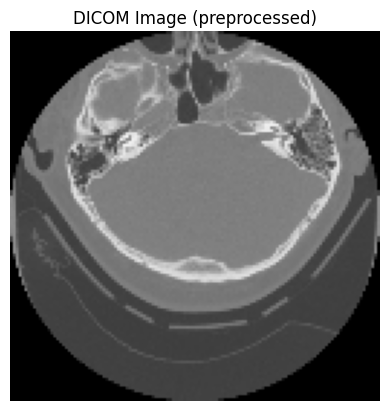

In [34]:
import matplotlib.pyplot as plt
plt.imshow(img_rgb)
plt.axis('off')
plt.title('DICOM Image (preprocessed)')
plt.show()


# To Load Pretrained Model 

94/94 [==============================] - 12s 131ms/step


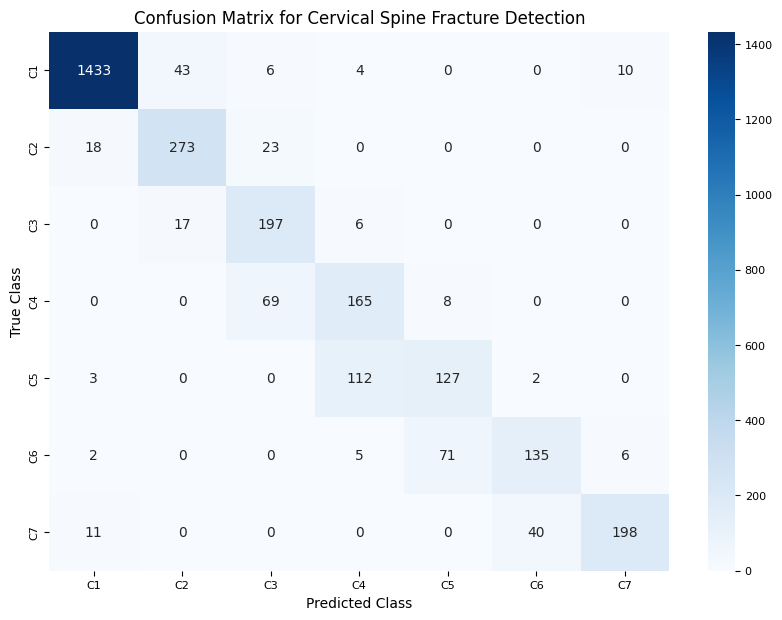

In [37]:
# Predict on the test data
y_pred_0 = model.predict(X_test)

# Threshold the predictions to binary values
threshold = 0.5
y_pred_binary_0 = (y_pred_0 > threshold).astype(int)

# Get the confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_binary_0.argmax(axis=1))

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["C1", "C2", "C3", "C4", "C5", "C6", "C7"], yticklabels=["C1", "C2", "C3", "C4", "C5", "C6", "C7"])
plt.title("Confusion Matrix for Cervical Spine Fracture Detection")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

94/94 [==============================] - 12s 127ms/step


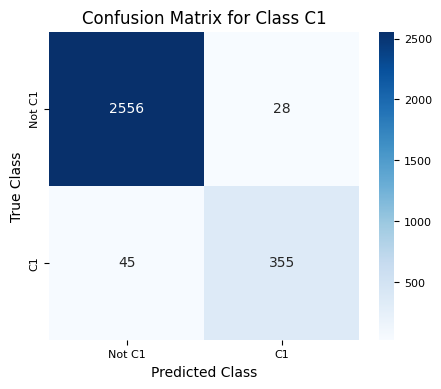

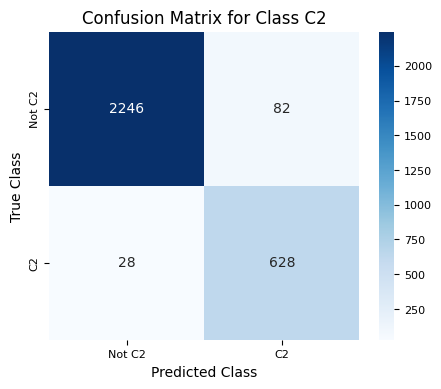

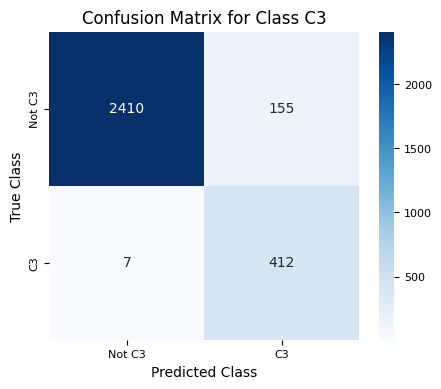

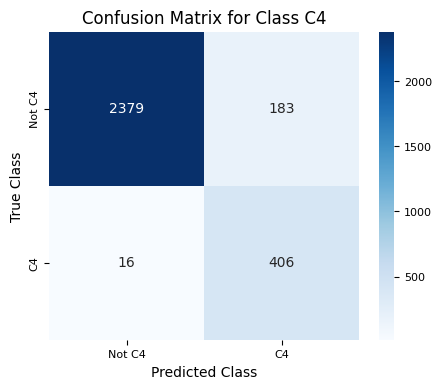

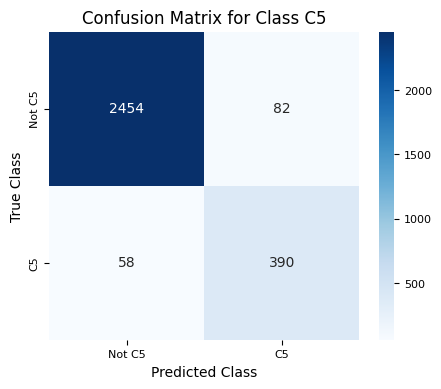

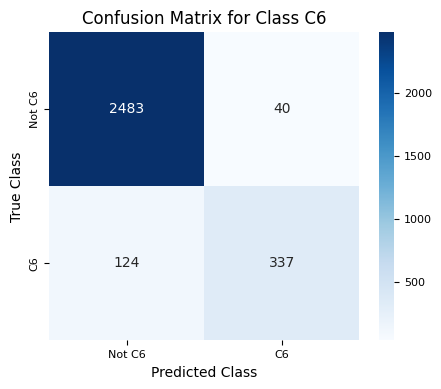

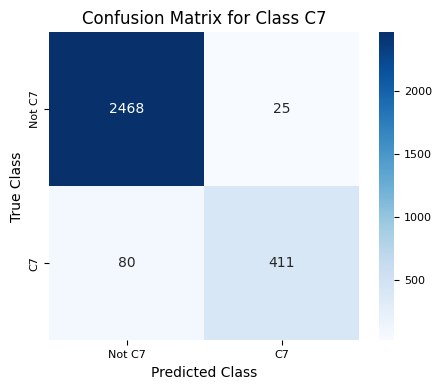

In [38]:
# Predict on the test data
y_pred_0 = model.predict(X_test)

# Threshold the predictions to binary values
threshold = 0.5
y_pred_binary_0 = (y_pred_0 > threshold).astype(int)

# Loop through each class to generate a separate confusion matrix
class_names = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]

for i, class_name in enumerate(class_names):
    # Create binary true labels for the class
    y_true_class = (y_test[:, i] == 1).astype(int)
    
    # Create binary predicted labels for the class
    y_pred_class = (y_pred_binary_0[:, i] == 1).astype(int)
    
    # Get the confusion matrix for the class
    cm = confusion_matrix(y_true_class, y_pred_class)
    
    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not " + class_name, class_name], yticklabels=["Not " + class_name, class_name])
    plt.title(f"Confusion Matrix for Class {class_name}")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

In [41]:
def compute_gradcam(model, img_idx, df, labels, layer_name='bn', W=128, H=128):    
    preprocessed_input, label = load_image(df, img_idx)
    print(label)
    preprocessed_img = np.expand_dims(preprocessed_input, axis=0)
    predictions = model.predict(preprocessed_img)
    
    ##############################
    print("Loading original image")
    plt.figure(figsize=(12, 2))
    plt.suptitle(f'Patient_ID: {seg_labels.loc[img_idx].StudyInstanceUID}| Slice: {seg_labels.loc[img_idx].slice}', fontsize=10)
    plt.subplot(1, 8, 1)
    plt.title("Original", fontsize=8)
    plt.axis('off')
    plt.imshow(preprocessed_input, cmap='gray')
    ##############################
    
    conv_output = model.get_layer(layer_name).output
    gradModel = Model(
                inputs=[model.inputs],
                outputs=[conv_output,model.output])
    
    for i in range(len(labels)):
#         if labels[i] in selected_labels:
        print(f"Generating gradcam for class {labels[i]}")

        cls = i # specific class output probability
        with tf.GradientTape() as tape:
            (convOutputs, pred) = gradModel(preprocessed_img)
            loss = pred[:, cls]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        output, grads_val = convOutputs[0, :], grads[0, :, :, :] #no need of batch information

        weights = np.mean(grads_val, axis=(0, 1))
        cam = np.dot(output, weights)

        # Process CAM
        cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
        cam = np.maximum(cam, 0)
        gradcam = cam / cam.max()

        ###############################
        plt.subplot(1, 8, i+2)
        plt.title(f"{labels[i]}: A={label[i]},P={predictions[0][i]:.3f}", fontsize=8)
        plt.axis('off')
        plt.imshow(preprocessed_input,cmap='gray')

        #value = np.array(min(0.5, predictions[0][i])).reshape(1,1)
        value = min(0.5, predictions[0][i])
        value = np.repeat(value,W*H).reshape(W,H)
        plt.imshow(gradcam, cmap='jet', alpha=value)
        #################################


27293
[0, 1, 0, 0, 0, 0, 0]
1/1 [==============================] - 2s 2s/step
Loading original image
Generating gradcam for class C1
Generating gradcam for class C2
Generating gradcam for class C3
Generating gradcam for class C4
Generating gradcam for class C5
Generating gradcam for class C6


/tmp/ipykernel_32/1341453422.py:41: RuntimeWarning: invalid value encountered in divide
  gradcam = cam / cam.max()


Generating gradcam for class C7


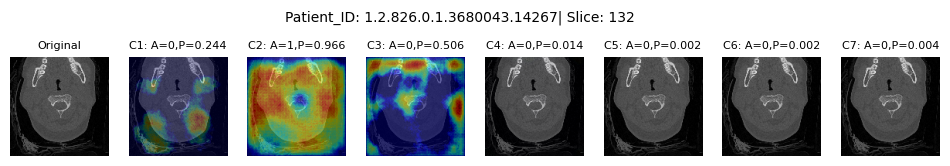

In [42]:
layer_name_2='conv2d_210'  #'conv5_block16_2_conv'
img_idx = 27293 #np.random.randint(0, len(seg_labels))
print(img_idx)
compute_gradcam(model=model_0, img_idx=img_idx, df=seg_labels, labels=labels, layer_name=layer_name_2)

73
[0, 0, 0, 0, 0, 0, 1]
1/1 [==============================] - 0s 32ms/step
Loading original image
Generating gradcam for class C1
Generating gradcam for class C2
Generating gradcam for class C3
Generating gradcam for class C4
Generating gradcam for class C5
Generating gradcam for class C6
Generating gradcam for class C7


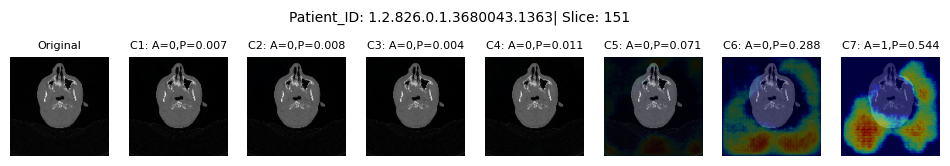

In [43]:
img_idx = 73 #np.random.randint(0, len(seg_labels))
print(img_idx)
compute_gradcam(model=model, img_idx=img_idx, df=seg_labels, labels=labels, layer_name=layer_name_2)

980
[1, 1, 0, 0, 0, 0, 0]
1/1 [==============================] - 0s 32ms/step
Loading original image
Generating gradcam for class C1
Generating gradcam for class C2
Generating gradcam for class C3
Generating gradcam for class C4
Generating gradcam for class C5
Generating gradcam for class C6
Generating gradcam for class C7


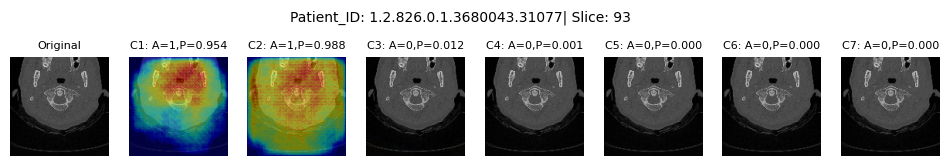

In [44]:
img_idx = 980 #np.random.randint(0, len(seg_labels))
print(img_idx)
compute_gradcam(model=model, img_idx=img_idx, df=seg_labels, labels=labels, layer_name=layer_name_2)

1/1 [==============================] - 2s 2s/step
All vertebrae fracture probabilities:
  C1: 0.1191
  C2: 0.9602
  C3: 0.6437
  C4: 0.0212
  C5: 0.0016
  C6: 0.0008
  C7: 0.0023
Fracture detected in vertebrae: C2, C3
Probabilities (above threshold): {'C2': '0.9602', 'C3': '0.6437'}


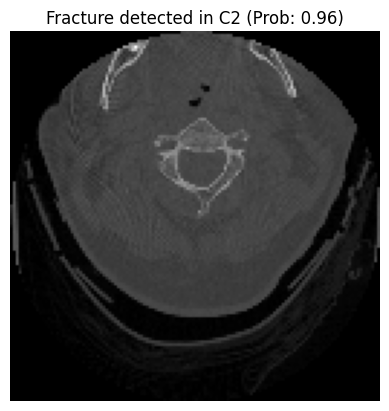

In [ ]:
import pydicom as dicom
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

# Replace this with your loaded model variable
model_0 = load_model('/kaggle/working/model_0_CustomCNN.h5')

def get_pixels_hu(img):
    """Convert DICOM pixel data to Hounsfield Units (HU) and resize to 128x128."""
    image = cv2.resize(img.pixel_array, (128, 128), interpolation=cv2.INTER_NEAREST)
    image = image.astype(np.int16)
    image[image <= -1000] = 0
    intercept = getattr(img, 'RescaleIntercept', 0)
    slope = getattr(img, 'RescaleSlope', 1)
    image = slope * image.astype(np.float64) + intercept
    return image.astype(np.int16)

def load_and_preprocess_image(path):
    """Load DICOM image, convert to HU, normalize and convert to RGB 128x128."""
    img = dicom.dcmread(path)
    hu_image = get_pixels_hu(img)
    hu_image = hu_image - np.min(hu_image)
    if np.max(hu_image) != 0:
        hu_image = hu_image / np.max(hu_image)
    hu_image = (hu_image * 255).astype(np.uint8)
    rgb_image = cv2.cvtColor(hu_image, cv2.COLOR_GRAY2RGB)
    return rgb_image

def predict_fracture(image_path, model, threshold=0.5):
    vertebra_labels = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

    # Load and preprocess image
    img = load_and_preprocess_image(image_path)
    input_img = img_to_array(img) / 255.0
    input_img = np.expand_dims(input_img, axis=0)  # Add batch dimension

    # Predict probabilities
    proba = model.predict(input_img)[0]

    # Print all probabilities for all vertebrae
    print("All vertebrae fracture probabilities:")
    for v, p in zip(vertebra_labels, proba):
        print(f"  {v}: {p:.4f}")

    # Find vertebrae with probability > threshold
    fractured_indices = [i for i, p in enumerate(proba) if p > threshold]

    # Display results
    plt.imshow(img)
    plt.axis('off')

    if len(fractured_indices) == 0:
        plt.title(f"No fracture detected (all probabilities ≤ {threshold:.2f})")
        print("No fracture detected.")
    else:
        # Find vertebra with highest probability among fractured
        max_index = fractured_indices[np.argmax(proba[fractured_indices])]
        max_vertebra = vertebra_labels[max_index]
        max_prob = proba[max_index]

        fractured_vertebrae = [vertebra_labels[i] for i in fractured_indices]
        fractured_probs = [proba[i] for i in fractured_indices]

        plt.title(f"Fracture detected in {max_vertebra} (Prob: {max_prob:.2f})")
        print(f"Fracture detected in vertebrae: {', '.join(fractured_vertebrae)}")
        print("Probabilities (above threshold):", {v: f"{p:.4f}" for v, p in zip(fractured_vertebrae, fractured_probs)})

    plt.show()
    plt.show()

# Example usage:
image_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/test_images/1.2.826.0.1.3680043.22327/101.dcm'
predict_fracture(image_path, model_0)


1/1 [==============================] - 0s 34ms/step
All vertebrae fracture probabilities:
  C1: 0.0144
  C2: 0.0168
  C3: 0.0131
  C4: 0.0117
  C5: 0.0031
  C6: 0.0006
  C7: 0.0018
No fracture detected.


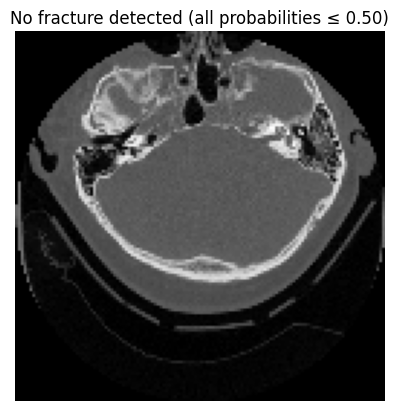

In [59]:
# Example usage:
image_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/test_images/1.2.826.0.1.3680043.22327/12.dcm'
predict_fracture(image_path, model_0)

1/1 [==============================] - 0s 33ms/step
All vertebrae fracture probabilities:
  C1: 0.0059
  C2: 0.0110
  C3: 0.0036
  C4: 0.0083
  C5: 0.0509
  C6: 0.5635
  C7: 0.8987
Fracture detected in vertebrae: C6, C7
Probabilities (above threshold): {'C6': '0.5635', 'C7': '0.8987'}


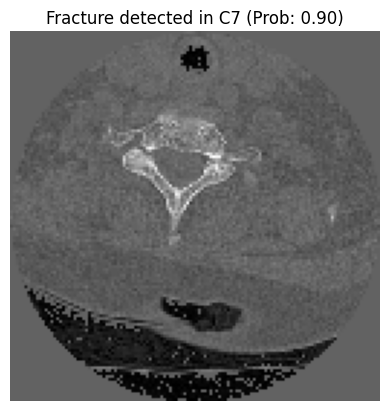

In [60]:
# Example usage:
image_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/test_images/1.2.826.0.1.3680043.5876/300.dcm'
predict_fracture(image_path, model_0)

1/1 [==============================] - 0s 33ms/step
All vertebrae fracture probabilities:
  C1: 0.9135
  C2: 0.9698
  C3: 0.0227
  C4: 0.0020
  C5: 0.0010
  C6: 0.0018
  C7: 0.0016
Fracture detected in vertebrae: C1, C2
Probabilities (above threshold): {'C1': '0.9135', 'C2': '0.9698'}


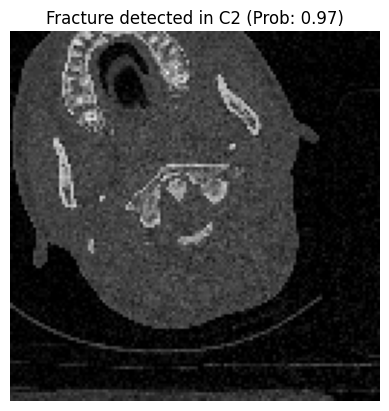

In [61]:
# Example usage:
image_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/test_images/1.2.826.0.1.3680043.25399/124.dcm'
predict_fracture(image_path, model_0)

1/1 [==============================] - 0s 34ms/step
All vertebrae fracture probabilities:
  C1: 0.0158
  C2: 0.0124
  C3: 0.0030
  C4: 0.0036
  C5: 0.0062
  C6: 0.0039
  C7: 0.0090
No fracture detected.


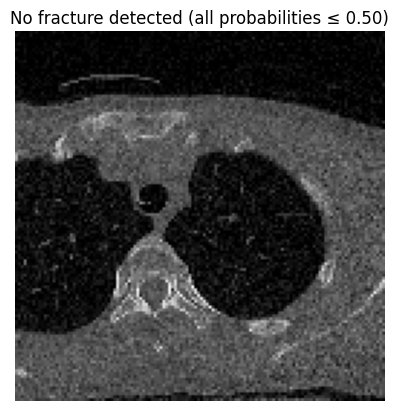

In [62]:
# Example usage:
image_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/test_images/1.2.826.0.1.3680043.25399/524.dcm'
predict_fracture(image_path, model_0)

1/1 [==============================] - 0s 33ms/step
All vertebrae fracture probabilities:
  C1: 0.0137
  C2: 0.0074
  C3: 0.0018
  C4: 0.0053
  C5: 0.0198
  C6: 0.0326
  C7: 0.0710
No fracture detected.


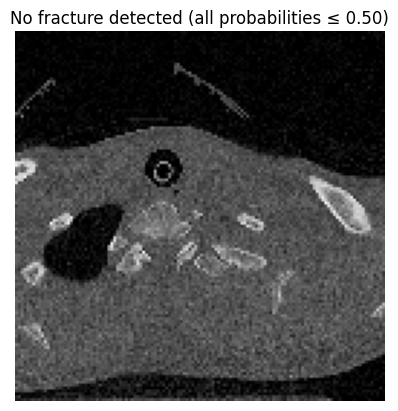

In [63]:
# Example usage:
image_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/test_images/1.2.826.0.1.3680043.25399/424.dcm'
predict_fracture(image_path, model_0)

1/1 [==============================] - 0s 39ms/step
All vertebrae fracture probabilities:
  C1: 0.0107
  C2: 0.0060
  C3: 0.0028
  C4: 0.0027
  C5: 0.0022
  C6: 0.0010
  C7: 0.0059
No fracture detected.


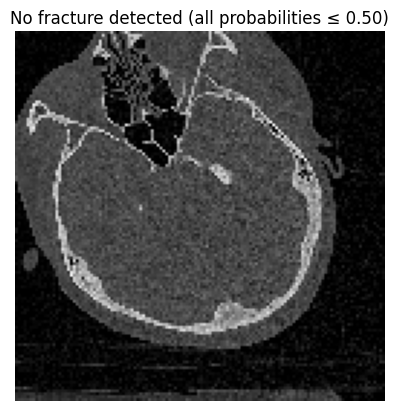

In [64]:
# Example usage:
image_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/test_images/1.2.826.0.1.3680043.25399/14.dcm'
predict_fracture(image_path, model_0)

1/1 [==============================] - 0s 33ms/step
All vertebrae fracture probabilities:
  C1: 0.0006
  C2: 0.0009
  C3: 0.0038
  C4: 0.2023
  C5: 0.9475
  C6: 0.7844
  C7: 0.0586
Fracture detected in vertebrae: C5, C6
Probabilities (above threshold): {'C5': '0.9475', 'C6': '0.7844'}


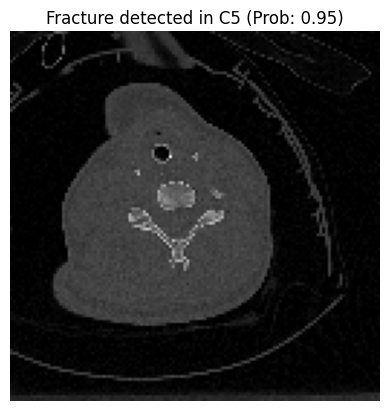

In [65]:
# Example usage:
image_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/test_images/1.2.826.0.1.3680043.25399/304.dcm'
predict_fracture(image_path, model_0)